#Cell 01 — Environment, paths, reproducibility

In [43]:
# === Cell 01: Environment, paths, reproducibility ===
import os, sys, math, random, shutil, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torchvision

warnings.filterwarnings("ignore")

def in_colab() -> bool:
    return "google.colab" in sys.modules

if in_colab():
    try:
        from google.colab import drive
        drive.mount("/content/drive", force_remount=False)
        print("[Env] Google Drive mounted.")
    except Exception as e:
        print(f"[Env][WARN] Drive mount failed: {e}")

# Root dirs (local)
PROJECT_ROOT  = Path("./project"); PROJECT_ROOT.mkdir(parents=True, exist_ok=True)
DATA_ROOT     = Path("./data");    DATA_ROOT.mkdir(parents=True, exist_ok=True)
CKPT_DIR      = PROJECT_ROOT / "checkpoints"; CKPT_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR       = PROJECT_ROOT / "logs";        LOG_DIR.mkdir(parents=True, exist_ok=True)

# Seeds
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

# Optional strict determinism (slower but reproducible)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Env] torch={torch.__version__}, torchvision={torchvision.__version__}, device={device}")

# Data path (edit if needed)
FER_CSV_PATH = Path("/content/drive/MyDrive/fer2013.csv") if in_colab() else Path("./fer2013.csv")
print(f"[Env] CSV path → {FER_CSV_PATH}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Env] Google Drive mounted.
[Env] torch=2.8.0+cu126, torchvision=0.23.0+cu126, device=cuda
[Env] CSV path → /content/drive/MyDrive/fer2013.csv


#Cell 02 — Global config (single source of truth)

In [44]:
# === Cell 02: Global config (single source of truth) ===
CONFIG = {
    # IO
    "FER_CSV_PATH": FER_CSV_PATH,
    "SAVE_BEST_PATH": CKPT_DIR / "best_fer.pth",
    # Data
    "IMG_SIZE": 96,
    "BATCH_SIZE": 192,         # tune for your GPU
    "NUM_WORKERS": 6,          # 4–8 is fine on Colab
    # Training toggles
    "USE_AUG": True,
    "USE_AUG_ADV": True,       # enables the advanced FER policy
    "AUG_ALPHA": 0.65,         # AugMix-lite blend
    "USE_MIXUP": True,
    "USE_CUTMIX": True,
    "USE_EMA": True,
    "USE_TTA": True,           # only for TEST; validation remains clean
    # Curriculum / late-phase controls
    "AUG_CAP_LATE": True,      # cap augmentation strength in final 30%
    "TAPER_MIX_LATE": True,    # taper mixing after 50% epochs
    # Compute
    "USE_AMP": torch.cuda.is_available(),
}

HP = {
    "EPOCHS": 50,
    "LR": 3e-4,
    "WD": 1e-4,
    "WARMUP_EPOCHS": 4,
    "LR_MIN": 1e-6,
    "PATIENCE": 8,
    "EMA_DECAY": 0.999,
    "MIXUP_ALPHA": 0.30,
    "CUTMIX_ALPHA": 1.00,
    "AUG_RAMP_EPOCHS": 0.30,   # fraction of total epochs
}

for k in sorted(CONFIG): print(f"[CFG] {k:16s}: {CONFIG[k]}")
for k in sorted(HP):     print(f"[HP ] {k:16s}: {HP[k]}")


[CFG] AUG_ALPHA       : 0.65
[CFG] AUG_CAP_LATE    : True
[CFG] BATCH_SIZE      : 192
[CFG] FER_CSV_PATH    : /content/drive/MyDrive/fer2013.csv
[CFG] IMG_SIZE        : 96
[CFG] NUM_WORKERS     : 6
[CFG] SAVE_BEST_PATH  : project/checkpoints/best_fer.pth
[CFG] TAPER_MIX_LATE  : True
[CFG] USE_AMP         : True
[CFG] USE_AUG         : True
[CFG] USE_AUG_ADV     : True
[CFG] USE_CUTMIX      : True
[CFG] USE_EMA         : True
[CFG] USE_MIXUP       : True
[CFG] USE_TTA         : True
[HP ] AUG_RAMP_EPOCHS : 0.3
[HP ] CUTMIX_ALPHA    : 1.0
[HP ] EMA_DECAY       : 0.999
[HP ] EPOCHS          : 50
[HP ] LR              : 0.0003
[HP ] LR_MIN          : 1e-06
[HP ] MIXUP_ALPHA     : 0.3
[HP ] PATIENCE        : 8
[HP ] WARMUP_EPOCHS   : 4
[HP ] WD              : 0.0001


#Cell 03 — Load FER2013 and split

In [45]:
# === Cell 03: Load FER2013 and split ===
from pathlib import Path
FER_CSV_PATH = Path(CONFIG["FER_CSV_PATH"])
assert FER_CSV_PATH.exists(), f"CSV not found: {FER_CSV_PATH}"

df = pd.read_csv(FER_CSV_PATH)
assert {"emotion","pixels"}.issubset(set(df.columns)), f"Bad columns: {df.columns.tolist()}"
print(df["Usage"].value_counts())

train_df = df[df["Usage"]=="Training"].reset_index(drop=True)
val_df   = df[df["Usage"]=="PublicTest"].reset_index(drop=True)
test_df  = df[df["Usage"]=="PrivateTest"].reset_index(drop=True)
print(f"[Split] train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")


Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64
[Split] train=28709, val=3589, test=3589


#Cell 04 — Dataset (48→96), returns tensor in [0..255], 1×H×W

In [46]:
# === Cell 04: Dataset (48→96), returns [1,H,W] in 0..255 float ===
import torchvision.transforms.functional as VF
from torch.utils.data import Dataset

class FER2013Dataset(Dataset):
    def __init__(self, df: pd.DataFrame, img_size: int = 96):
        self.df = df.reset_index(drop=True)
        self.img_size = int(img_size)
        if len(self.df) > 0:
            _ = self._get_x(0)

    def _get_x(self, i: int) -> torch.Tensor:
        px = self.df.iloc[i]["pixels"]
        arr = np.fromstring(str(px), sep=" ", dtype=np.float32)
        assert arr.size == 48*48, f"Row {i}: expected 2304 pixels, got {arr.size}"
        x = torch.from_numpy(arr.reshape(48, 48)).unsqueeze(0)  # [1,48,48], float32 in 0..255
        x = VF.resize(
            x,
            [self.img_size, self.img_size],
            interpolation=torchvision.transforms.InterpolationMode.BILINEAR,
            antialias=True,
        )
        return x

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        x = self._get_x(i).contiguous()  # [1,H,W], float32 0..255
        y = int(self.df.iloc[i]["emotion"])
        return x, y

IMG_SIZE = int(CONFIG["IMG_SIZE"])
train_ds = FER2013Dataset(train_df, IMG_SIZE)
val_ds   = FER2013Dataset(val_df,   IMG_SIZE)
test_ds  = FER2013Dataset(test_df,  IMG_SIZE)
print("[Dataset] ready.")


[Dataset] ready.


#Cell 05 — DataLoaders

In [47]:
# === Cell 05: DataLoaders ===
from torch.utils.data import DataLoader

BATCH = int(CONFIG["BATCH_SIZE"])
NUM_WORKERS = int(CONFIG["NUM_WORKERS"])
PIN = bool(torch.cuda.is_available())  # safer on CPU-only runs

train_dl = DataLoader(
    train_ds, batch_size=BATCH, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=PIN, persistent_workers=(NUM_WORKERS>0)
)
val_dl   = DataLoader(
    val_ds,   batch_size=BATCH*2, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=PIN, persistent_workers=(NUM_WORKERS>0)
)
test_dl  = DataLoader(
    test_ds,  batch_size=BATCH*2, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=PIN, persistent_workers=(NUM_WORKERS>0)
)

xb, yb = next(iter(val_dl))
print(f"[Check] val batch: {xb.shape}, range [{xb.min():.1f},{xb.max():.1f}]")


[Check] val batch: torch.Size([384, 1, 96, 96]), range [0.0,255.0]


#Cell 06 — Advanced augmentation primitives (photometric, geometric, occlusion, elastic)

In [48]:
# === Cell 06: Advanced augmentation primitives (grayscale) ===
import io
from PIL import Image, ImageOps
import torch.nn.functional as F

def _to_pil_gray(x255: torch.Tensor) -> Image.Image:
    x = x255.clamp(0,255).to(torch.uint8).squeeze(0).cpu().numpy()
    return Image.fromarray(x, mode='L')

def _from_pil_gray(img: Image.Image) -> torch.Tensor:
    return torch.tensor(np.array(img, dtype=np.uint8), dtype=torch.float32).unsqueeze(0)

def _clip(x): return x.clamp(0.0, 255.0)

# photometric
def gauss_noise(x, sigma=0.02): return _clip(x + torch.randn_like(x)*(sigma*255.))
def rand_gamma(x, gmin=0.85, gmax=1.25):
    g = random.uniform(gmin,gmax); x01=(x/255.).clamp(0,1); return (x01**g)*255.
def rand_contrast(x, scale=0.25):
    c = 1.0+random.uniform(-scale,scale); m=x.mean(dim=(1,2),keepdim=True); return _clip((x-m)*c+m)
def rand_equalize(x):
    img=_to_pil_gray(x); img=ImageOps.equalize(img); return _from_pil_gray(img).to(x.dtype).to(x.device)
def rand_jpeg(x, qmin=55, qmax=85):
    img=_to_pil_gray(x); buf=io.BytesIO(); img.save(buf,format='JPEG',quality=random.randint(qmin,qmax))
    buf.seek(0); img2=Image.open(buf).convert('L'); return _from_pil_gray(img2).to(x.dtype).to(x.device)
def rand_vignette(x, strength=0.25):
    _,H,W=x.shape; yy,xx=torch.meshgrid(torch.linspace(-1,1,H,device=x.device),
                                        torch.linspace(-1,1,W,device=x.device),indexing='ij')
    r=torch.sqrt(xx**2+yy**2); mask=1.0-strength*(r/r.max()).clamp(0,1)
    return _clip(x*mask.unsqueeze(0))

# Range-safe blur: convert to [0,1] → blur → back to [0,255]
def rand_blur(x, k=3):
    x01 = (x/255.).clamp(0,1)
    y01 = torchvision.transforms.functional.gaussian_blur(x01, kernel_size=k)
    return (y01 * 255.0).clamp(0,255)

# geometric
def rand_affine_small(x, max_rot=12, max_trans=0.08, max_shear=8.0, max_scale=0.08):
    H,W=x.shape[-2:]
    angle=random.uniform(-max_rot,max_rot)
    trans=[int(random.uniform(-max_trans,max_trans)*W),int(random.uniform(-max_trans,max_trans)*H)]
    scale=1.0+random.uniform(-max_scale,max_scale)
    shear=[random.uniform(-max_shear,max_shear),0.0]
    return torchvision.transforms.functional.affine(x, angle=angle, translate=trans, scale=scale, shear=shear)

def rand_pad_crop(x, pad=3):
    _,H,W=x.shape; xpad=F.pad(x,(pad,pad,pad,pad),mode='reflect'); i=random.randint(0,2*pad); j=random.randint(0,2*pad)
    return xpad[:,i:i+H, j:j+W]

def rand_hflip(x, p=0.5): return torchvision.transforms.functional.hflip(x) if random.random()<p else x

# elastic
def rand_elastic(x, alpha=1.0, sigma=4.0):
    _,H,W=x.shape
    def _gkern(k=21,s=sigma):
        ax=torch.arange(k,device=x.device)-(k-1)/2; ker=torch.exp(-(ax**2)/(2*s*s)); ker/=ker.sum(); return ker
    k=21; gx=_gkern(k).view(1,1,1,k); gy=_gkern(k).view(1,1,k,1)
    dx=F.conv2d(F.conv2d(torch.randn(1,1,H,W,device=x.device),gx,padding=(0,k//2)),gy,padding=(k//2,0)).squeeze()*alpha
    dy=F.conv2d(F.conv2d(torch.randn(1,1,H,W,device=x.device),gx,padding=(0,k//2)),gy,padding=(k//2,0)).squeeze()*alpha
    yy,xx=torch.meshgrid(torch.linspace(-1,1,H,device=x.device),
                         torch.linspace(-1,1,W,device=x.device),indexing='ij')
    xx=(xx+dx/(W/2)).clamp(-1,1); yy=(yy+dy/(H/2)).clamp(-1,1)
    grid=torch.stack([xx,yy],dim=-1).unsqueeze(0)
    return F.grid_sample(x.unsqueeze(0), grid, mode='bilinear', padding_mode='border', align_corners=True).squeeze(0)

# occlusio


#Cell 07 — AugMix‑lite and advanced augmentation builder (returns [-1,1])

In [49]:
# === Cell 07: AugMix-lite + advanced augmentation builder (→ [-1,1]) ===
def _apply_bank(x, bank, k=2):
    y=x.clone()
    for _ in range(k):
        y = random.choice(bank)(y)
    return y

def augmix_lite(x, banks, alpha=0.65, branches=2, depth=2):
    mix=x.clone()
    for _ in range(branches):
        y=_apply_bank(x, random.choice(banks), k=depth)
        mix=mix+y
    mix = mix / (branches+1.0)
    return (1-alpha)*x + alpha*mix

def build_advanced_fer_augment(strength: float):
    s=float(max(0.0,min(1.0,strength)))
    # probabilities
    p_photo=0.7*(0.5+0.5*s); p_geom=0.6*(0.5+0.5*s); p_occl=0.40*(0.5+0.5*s)
    p_equal=0.20*s; p_blur=0.15*s
    # magnitudes
    gamma_rng=(0.85-0.15*s, 1.20+0.05*s)
    contrast=0.20+0.10*s
    jpeg_q=(55-int(10*s), 85)
    vignette=0.15+0.20*s
    elastic_a=0.6+0.8*s
    rot=10+5*s; shear=6+4*s; trans=0.06+0.03*s; scale=0.06+0.04*s

    photometric_bank = [
        lambda z: gauss_noise(z, sigma=0.015+0.02*s),
        lambda z: rand_gamma(z, *gamma_rng),
        lambda z: rand_contrast(z, scale=contrast),
        lambda z: rand_jpeg(z, qmin=jpeg_q[0], qmax=jpeg_q[1]),
        lambda z: rand_vignette(z, strength=vignette),
    ]
    geometric_bank = [
        lambda z: rand_affine_small(z, max_rot=rot, max_trans=trans, max_shear=shear, max_scale=scale),
        lambda z: rand_pad_crop(z, pad=3),
        lambda z: rand_hflip(z, p=0.5),
        lambda z: rand_elastic(z, alpha=elastic_a, sigma=4.0),
    ]
    occlusion_bank = [
        lambda z: band_occlusion(z, mode='eyes',  frac=0.16+0.06*s),
        lambda z: band_occlusion(z, mode='mouth', frac=0.16+0.06*s),
        lambda z: band_occlusion(z, mode='top',   frac=0.14+0.06*s),
        lambda z: localized_erasing(z, min_frac=0.01, max_frac=0.05),
    ]
    banks=[photometric_bank, geometric_bank, occlusion_bank]

    def _norm_to_m11(x255):
        x01=(x255/255.).clamp(0,1)
        return (x01 - 0.5) * 2.0

    def _augment(x):
        if random.random() < p_geom:  x = rand_pad_crop(x, pad=3)
        if random.random() < p_blur:  x = rand_blur(x, k=3)
        if random.random() < p_photo: x = random.choice(photometric_bank)(x)
        x = augmix_lite(x, banks=banks, alpha=CONFIG.get("AUG_ALPHA",0.65), branches=2, depth=2)
        if random.random() < p_geom:  x = random.choice(geometric_bank)(x)
        if random.random() < p_occl:  x = random.choice(occlusion_bank)(x)
        if random.random() < p_equal: x = rand_equalize(x)
        return _norm_to_m11(x)

    return _augment

FER_AUG_FACTORY = build_advanced_fer_augment if CONFIG.get("USE_AUG_ADV", False) else build_advanced_fer_augment


#Cell 08 — Metrics, class weights, losses (Label‑Smoothing + Focal composite)

In [50]:
# === Cell 08: Metrics, class weights, composite loss ===
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter

def accuracy(logits, targets): return (logits.argmax(1) == targets).float().mean()

def compute_class_weights(df) -> torch.Tensor:
    counts = Counter(int(e) for e in df["emotion"].tolist())
    total = sum(counts.values())
    w = torch.tensor([total / max(1, counts.get(c,1)) for c in range(7)], dtype=torch.float32)
    return w / w.mean()

CLASS_WEIGHTS = compute_class_weights(train_df)

class LabelSmoothingCE(nn.Module):
    def __init__(self, eps=0.10, reduction='mean'):
        super().__init__(); self.eps=eps; self.reduction=reduction
    def forward(self, logits, targets):
        n = logits.size(-1); logp = F.log_softmax(logits, dim=-1)
        with torch.no_grad():
            true = torch.zeros_like(logp).fill_(self.eps/(n-1))
            true.scatter_(1, targets.unsqueeze(1), 1.0 - self.eps)
        loss = -(true * logp).sum(dim=1)
        return loss.mean() if self.reduction=='mean' else loss

class FocalLoss(nn.Module):
    def __init__(self, gamma=1.5, reduction='mean'):
        super().__init__(); self.g=gamma; self.reduction=reduction
    def forward(self, logits, targets):
        ce = F.cross_entropy(logits, targets, reduction='none')
        pt = torch.exp(-ce)
        fl = (1-pt).pow(self.g) * ce
        return fl.mean() if self.reduction=='mean' else fl

class SmoothedFocal(nn.Module):
    def __init__(self, eps=0.10, gamma=1.5, alpha=0.70, weight=None):
        super().__init__(); self.a=alpha; self.w=weight
        self.lsce = LabelSmoothingCE(eps); self.focal = FocalLoss(gamma)
    def forward(self, logits, targets):
        if self.w is not None:
            ce = F.cross_entropy(logits, targets, reduction='none', weight=self.w.to(logits.device))
            pt = torch.exp(-ce); fl = (1-pt).pow(1.5) * ce
            ls = self.lsce(logits, targets)
            return self.a*ls + (1-self.a)*fl.mean()
        return self.a*self.lsce(logits, targets) + (1-self.a)*self.focal(logits, targets)


#Cell 09 — MixUp / CutMix and mixed criterion

In [51]:
# === Cell 09: MixUp / CutMix and mixed criterion ===
def mixup_data(x, y, alpha=0.2):
    if alpha <= 0.0: return x, y, 1.0, None
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    return lam*x + (1-lam)*x[idx], (y, y[idx]), lam, idx

def cutmix_data(x, y, alpha=1.0, min_lam=0.3, max_lam=0.7):
    if alpha <= 0.0: return x, y, 1.0, None
    lam = float(np.clip(np.random.beta(alpha, alpha), min_lam, max_lam))
    B,C,H,W = x.size(); idx = torch.randperm(B, device=x.device)
    cut_w = int(W * math.sqrt(1 - lam)); cut_h = int(H * math.sqrt(1 - lam))
    cx, cy = np.random.randint(W), np.random.randint(H)
    x1, x2 = np.clip(cx - cut_w//2, 0, W), np.clip(cx + cut_w//2, 0, W)
    y1, y2 = np.clip(cy - cut_h//2, 0, H), np.clip(cy + cut_h//2, 0, H)
    x[:, :, y1:y2, x1:x2] = x[idx, :, y1:y2, x1:x2]
    lam = 1 - ((x2-x1)*(y2-y1) / (W*H + 1e-9))
    return x, (y, y[idx]), lam, idx

def mixed_criterion(criterion, logits, targets_mix, lam):
    if isinstance(targets_mix, tuple):
        y_a, y_b = targets_mix
        return lam * criterion(logits, y_a) + (1-lam) * criterion(logits, y_b)
    return criterion(logits, targets_mix)


#Cell 10 — EMA (exponential moving average)

In [52]:
# === Cell 10: EMA ===
import torch.nn as nn

class EMA:
    def __init__(self, model: nn.Module, decay: float = 0.999):
        self.decay=float(decay); self.shadow={}; self.backup={}
        for n,p in model.named_parameters():
            if p.requires_grad: self.shadow[n]=p.data.clone()
    def update(self, model):
        for n,p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n]=(1-self.decay)*p.data + self.decay*self.shadow[n]
    def apply_shadow(self, model):
        self.backup={}
        for n,p in model.named_parameters():
            if p.requires_grad:
                self.backup[n]=p.data.clone(); p.data=self.shadow[n].clone()
    def restore(self, model):
        for n,p in model.named_parameters():
            if p.requires_grad:
                p.data=self.backup[n].clone()
        self.backup={}


#Cell 11 — CBAM and Sobel stem

In [53]:
# === Cell 11: CBAM + Sobel stem ===
import torch.nn.functional as F
import torch.nn as nn
import torch

class CBAM(nn.Module):
    def __init__(self, ch, r=8):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Conv2d(ch, max(1,ch//r), 1, bias=True), nn.ReLU(inplace=True),
            nn.Conv2d(max(1,ch//r), ch, 1, bias=True)
        )
        self.spatial = nn.Sequential(nn.Conv2d(2,1,kernel_size=7,padding=3,bias=False), nn.Sigmoid())
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        ca = self.sigmoid(self.mlp(F.adaptive_avg_pool2d(x,1) + F.adaptive_max_pool2d(x,1)))
        x = x * ca
        ms = torch.cat([x.mean(1,keepdim=True), x.max(1,keepdim=True)[0]], dim=1)
        return x * self.spatial(ms)

class SobelLayer(nn.Module):
    def __init__(self):
        super().__init__()
        kx = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], dtype=torch.float32)
        ky = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]], dtype=torch.float32)
        w  = torch.stack([kx, ky]).unsqueeze(1)   # (2,1,3,3)
        self.register_buffer('w', w)
    def forward(self, x):                          # x: [B,1,H,W]
        edges = F.conv2d(x, self.w, padding=1)     # [B,2,H,W]
        return torch.cat([x, edges], dim=1)        # [B,3,H,W]


#Cell 12 — Model: EfficientNet‑B0 + CBAM + Sobel

In [54]:
# === Cell 12: HybridEffNet (EfficientNet‑B0 + CBAM + Sobel) ===
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

CLASSIFIER_DROPOUT = 0.30
USE_CBAM = True

class HybridEffNet(nn.Module):
    def __init__(self, num_classes=7, classifier_dropout=CLASSIFIER_DROPOUT, use_cbam=USE_CBAM):
        super().__init__()
        self.device = device
        base = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        self.sobel    = SobelLayer()          # 1→3 ch stem
        self.features = base.features
        self.pool     = nn.AdaptiveAvgPool2d(1)
        self.cbam     = CBAM(1280) if use_cbam else None
        self.bn       = nn.BatchNorm1d(1280)
        self.drop     = nn.Dropout(p=classifier_dropout)
        self.head     = nn.Linear(1280, num_classes)
        self.to(self.device)

    def forward(self, x1):                    # x1 in [-1,1], [B,1,H,W]
        x3 = self.sobel(x1)                   # [B,3,H,W]
        f  = self.features(x3)                # [B,1280,h,w]
        if self.cbam is not None:
            f = self.cbam(f)
        f  = self.pool(f).flatten(1)          # [B,1280]
        f  = self.bn(f)
        f  = self.drop(f)
        return self.head(f)


#Cell 13 — Optimizer, scheduler, early stopping

In [55]:
# === Cell 13: Optimizer, Warmup‑Cosine, EarlyStopping ===
def make_adamw(params, lr, wd): return torch.optim.AdamW(params, lr=lr, weight_decay=wd)

class WarmupCosine:
    def __init__(self, opt, warmup_epochs, max_epochs, lr_min=1e-6, lr_max=None):
        self.opt=opt; self.warmup=max(1,int(warmup_epochs)); self.maxe=int(max_epochs); self.t=0
        self.lr_min=lr_min; self.lr_max=lr_max if lr_max is not None else max(pg['lr'] for pg in opt.param_groups)
    def step(self):
        self.t += 1
        if self.t <= self.warmup:
            lr = self.lr_min + (self.lr_max - self.lr_min) * (self.t / self.warmup)
        else:
            tt = (self.t - self.warmup) / max(1,(self.maxe - self.warmup))
            lr = self.lr_min + 0.5*(self.lr_max - self.lr_min)*(1 + math.cos(math.pi*tt))
        for g in self.opt.param_groups: g['lr'] = lr
        return lr

class EarlyStopping:
    def __init__(self, patience=8, min_delta=1e-4):
        self.patience=int(patience); self.min_delta=float(min_delta); self.best=float('inf'); self.bad=0
    def step(self, val_loss):
        if val_loss < self.best - self.min_delta: self.best=val_loss; self.bad=0; return False
        self.bad += 1; return self.bad >= self.patience


#Cell 14 — Training loop with advanced aug, MixUp/CutMix, EMA, AMP

In [56]:
# === Cell 14: fit_with_aug (advanced aug + MixUp/CutMix + EMA + AMP) ===
def fit_with_aug(model: nn.Module, train_dl, val_dl, hp, cfg):
    device = model.device
    weight = CLASS_WEIGHTS.to(device)
    criterion = SmoothedFocal(eps=0.10, gamma=1.5, alpha=0.70, weight=weight)

    opt   = make_adamw(model.parameters(), lr=hp["LR"], wd=hp["WD"])
    sched = WarmupCosine(opt, warmup_epochs=hp["WARMUP_EPOCHS"], max_epochs=hp["EPOCHS"], lr_min=hp["LR_MIN"])
    stopper = EarlyStopping(patience=hp["PATIENCE"])
    ema = EMA(model, decay=hp["EMA_DECAY"]) if cfg["USE_EMA"] else None
    scaler = torch.cuda.amp.GradScaler(enabled=cfg["USE_AMP"])

    total_epochs = int(hp["EPOCHS"])
    ramp_epochs  = max(1, int(float(hp["AUG_RAMP_EPOCHS"]) * total_epochs))
    cap_late     = bool(cfg.get("AUG_CAP_LATE", True))
    taper_late   = bool(cfg.get("TAPER_MIX_LATE", True))

    history = []; best_val = float("inf")

    for epoch in range(1, total_epochs+1):
        model.train()
        s = 0.2 + 0.6 * min(1.0, epoch / ramp_epochs) if cfg["USE_AUG"] else 0.0
        if cap_late and epoch >= int(0.7*total_epochs): s = min(s, 0.6)
        augment = FER_AUG_FACTORY(s) if cfg["USE_AUG"] else None

        mixup_alpha  = float(hp["MIXUP_ALPHA"])
        cutmix_alpha = float(hp["CUTMIX_ALPHA"])
        use_cutmix   = bool(cfg["USE_CUTMIX"])
        if taper_late and epoch >= int(0.5*total_epochs):
            mixup_alpha  = max(0.1, mixup_alpha * 0.5)
            cutmix_alpha = max(0.5, cutmix_alpha * 0.5)
        if taper_late and epoch >= int(0.7*total_epochs):
            use_cutmix = False

        epoch_loss_sum, seen = 0.0, 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            if augment is not None:
                xb = torch.stack([augment(x) for x in xb])     # normalized [-1,1]
            else:
                xb = ((xb/255.) - 0.5) * 2.0                   # deterministic normalization

            opt.zero_grad(set_to_none=True)
            with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=cfg["USE_AMP"]):
                if cfg["USE_MIXUP"] or use_cutmix:
                    if use_cutmix and random.random() < 0.5:
                        xb, targets_mix, lam, _ = cutmix_data(xb, yb, alpha=cutmix_alpha, min_lam=0.3, max_lam=0.7)
                    else:
                        xb, targets_mix, lam, _ = mixup_data(xb, yb, alpha=mixup_alpha)
                    logits = model(xb)
                    loss = mixed_criterion(criterion, logits, targets_mix, lam)
                else:
                    logits = model(xb)
                    loss = criterion(logits, yb)

            scaler.scale(loss).backward()
            if torch.cuda.is_available(): scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            scaler.step(opt); scaler.update()
            if ema is not None: ema.update(model)

            bs = xb.size(0); epoch_loss_sum += loss.item()*bs; seen += bs

        # clean validation
        @torch.no_grad()
        def _eval(loader):
            model.eval(); losses=[]; accs=[]
            for xb, yb in loader:
                xb, yb = xb.to(device), yb.to(device)
                xb = ((xb/255.) - 0.5) * 2.0
                logits = model(xb)
                losses.append(criterion(logits, yb).item())
                accs.append(accuracy(logits, yb).item())
            return float(np.mean(losses)), float(np.mean(accs))

        val_loss, val_acc = _eval(val_dl)
        lr_now = sched.step()
        train_loss = epoch_loss_sum / max(1, seen)
        history.append({"epoch":epoch, "train_loss":train_loss, "val_loss":val_loss, "val_acc":val_acc, "lr":lr_now})
        print(f"[{epoch:03d}/{total_epochs}] train={train_loss:.4f}  val={val_loss:.4f}  acc={val_acc:.4f}  lr={lr_now:.2e}")

        if val_loss < best_val - 1e-6:
            best_val = val_loss
            torch.save({"model_state": model.state_dict()}, CONFIG["SAVE_BEST_PATH"])
        if stopper.step(val_loss):
            print("[EarlyStopping] stopping."); break

    return history, ema


#Cell 15 — Build model and quick probe

In [57]:
# === Cell 15: Build model and quick probe ===
model = HybridEffNet(num_classes=7, classifier_dropout=0.30, use_cbam=True)
model.train()
xb, yb = next(iter(train_dl))
xb = ((xb/255.) - 0.5) * 2.0
with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=CONFIG["USE_AMP"]):
    logits = model(xb.to(model.device))
    loss = F.cross_entropy(logits, yb.to(model.device))
loss.backward(); model.zero_grad(set_to_none=True)
print(f"[Probe] logits={tuple(logits.shape)}, loss={loss.item():.4f}")


[Probe] logits=(192, 7), loss=2.1074


Cell 16 — Train (main run)
# === Cell 16: Train main run ===
history, ema_obj = fit_with_aug(model, train_dl, val_dl, HP, CONFIG)

In [58]:
# === Cell 16: Train main run ===
history, ema_obj = fit_with_aug(model, train_dl, val_dl, HP, CONFIG)


[001/50] train=1.4822  val=1.2242  acc=0.4529  lr=7.57e-05
[002/50] train=1.3727  val=1.1776  acc=0.4885  lr=1.50e-04
[003/50] train=1.3465  val=1.1199  acc=0.5103  lr=2.25e-04
[004/50] train=1.2914  val=1.0820  acc=0.5424  lr=3.00e-04
[005/50] train=1.2779  val=1.0364  acc=0.5728  lr=3.00e-04
[006/50] train=1.2559  val=1.0154  acc=0.5748  lr=2.99e-04
[007/50] train=1.2288  val=1.0108  acc=0.5880  lr=2.97e-04
[008/50] train=1.2034  val=0.9832  acc=0.6086  lr=2.94e-04
[009/50] train=1.1775  val=0.9821  acc=0.6179  lr=2.91e-04
[010/50] train=1.1779  val=0.9614  acc=0.6243  lr=2.88e-04
[011/50] train=1.1760  val=0.9402  acc=0.6489  lr=2.83e-04
[012/50] train=1.1587  val=0.9498  acc=0.6355  lr=2.78e-04
[013/50] train=1.1890  val=0.9382  acc=0.6417  lr=2.73e-04
[014/50] train=1.1340  val=0.9177  acc=0.6495  lr=2.66e-04
[015/50] train=1.1504  val=0.9362  acc=0.6454  lr=2.60e-04
[016/50] train=1.1504  val=0.9234  acc=0.6474  lr=2.53e-04
[017/50] train=1.1599  val=0.9150  acc=0.6570  lr=2.45e-

# === Cell 17: Optional late-phase clean fine-tune (short tail) ===

In [61]:
# === Cell 17: Optional late-phase clean fine-tune (short tail) ===
from copy import deepcopy

if Path(CONFIG["SAVE_BEST_PATH"]).exists():
    ckpt = torch.load(CONFIG["SAVE_BEST_PATH"], map_location="cpu")
    model.load_state_dict(ckpt["model_state"]); model.to(model.device).train()

    cfg_tail = dict(CONFIG);  cfg_tail.update({"USE_AUG": False, "USE_MIXUP": False, "USE_CUTMIX": False})
    HP_TAIL = dict(HP, EPOCHS=8, LR=3e-5, LR_MIN=1e-6, PATIENCE=max(12, HP["PATIENCE"]))
    criterion_tail = LabelSmoothingCE(eps=0.05)
    opt = make_adamw(model.parameters(), lr=HP_TAIL["LR"], wd=HP_TAIL["WD"])
    sched = WarmupCosine(opt, warmup_epochs=1, max_epochs=HP_TAIL["EPOCHS"], lr_min=HP_TAIL["LR_MIN"])
    ema_tail = EMA(model, decay=0.9995)

    for ep in range(1, HP_TAIL["EPOCHS"]+1):
        model.train()
        for xb, yb in train_dl:
            xb, yb = xb.to(model.device), yb.to(model.device)
            xb = ((xb/255.) - 0.5)*2.0
            opt.zero_grad(set_to_none=True)
            with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=CONFIG["USE_AMP"]):
                loss = criterion_tail(model(xb), yb)
            loss.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step(); ema_tail.update(model)
        sched.step()
        ema_tail.apply_shadow(model)
        with torch.no_grad():
            model.eval()
            va = []
            for xb, yb in val_dl:
                xb, yb = xb.to(model.device), yb.to(model.device)
                xb = ((xb/255.) - 0.5)*2.0
                va.append(accuracy(model(xb), yb).item())
        ema_tail.restore(model)
        print(f"[Tail {ep:02d}] val_acc={np.mean(va):.4f}")


[Tail 01] val_acc=0.6865
[Tail 02] val_acc=0.6865
[Tail 03] val_acc=0.6871
[Tail 04] val_acc=0.6863
[Tail 05] val_acc=0.6845
[Tail 06] val_acc=0.6842
[Tail 07] val_acc=0.6835
[Tail 08] val_acc=0.6847


# === Cell 18: Evaluation (val clean; test clean + optional TTA) ===

In [66]:
# === Cell 20: Optional BatchNorm recalibration (clean, device‑safe) ===
from torch.optim.swa_utils import update_bn
import torch, copy
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

def has_batchnorm(m: nn.Module) -> bool:
    return any(isinstance(x, nn.modules.batchnorm._BatchNorm) for x in m.modules())

# --- 0) Evaluation transform from the validation loader (if available) ---
def _get_eval_transform():
    if 'val_dl' in globals() and hasattr(val_dl, 'dataset') and hasattr(val_dl.dataset, 'transform'):
        return val_dl.dataset.transform
    return None

EVAL_TF = _get_eval_transform()

# --- 1) Build a CLEAN train loader that uses the eval transform (no aug) ---
class _TransformView(Dataset):
    """Wrap an existing Dataset and override its transform for __getitem__."""
    def __init__(self, base_ds, transform):
        self.base = base_ds
        self.transform = transform
    def __len__(self):  return len(self.base)
    def __getitem__(self, i):
        x, y = self.base[i]
        if self.transform is not None:
            x = self.transform(x)
        return x, y

if EVAL_TF is not None:
    train_ds_clean = _TransformView(train_dl.dataset, EVAL_TF)
    train_dl_clean = DataLoader(
        train_ds_clean,
        batch_size=val_dl.batch_size,   # match val/test batch size
        shuffle=False,
        num_workers=val_dl.num_workers,
        pin_memory=True,
        persistent_workers=True
    )
else:
    print("[BN][WARN] No eval transform detected; reusing train_dl with explicit normalization.")
    train_dl_clean = train_dl

# --- 2) BN recalibration ---
if has_batchnorm(model):
    print("[BN] Recalibrating BN running stats...")
    dev = next(model.parameters()).device
    was_training = model.training
    model.train()

    # If evaluating EMA weights, apply them BEFORE recalibration.
    # try: ema_tail.apply_shadow(model)
    # except NameError: pass

    @torch.no_grad()
    def _clean_iter(dloader):
        for xb, _ in dloader:
            xb = xb.to(dev, non_blocking=True)
            if EVAL_TF is None:                 # only if we didn't inherit Normalize
                xb = ((xb / 255.) - 0.5) * 2.0   # [-1, 1]
            yield xb                             # update_bn expects the input tensor

    update_bn(_clean_iter(train_dl_clean), model)
    model.train(was_training); model.eval()
    print("[BN] Done.")

    # --- 3) Quick clean evaluation (consistent with above normalization) ---
    @torch.no_grad()
    def _eval_quick(loader):
        model.eval()
        correct = total = 0
        dev = next(model.parameters()).device
        for xb, yb in loader:
            xb, yb = xb.to(dev, non_blocking=True), yb.to(dev, non_blocking=True)
            if EVAL_TF is None:
                xb = ((xb / 255.) - 0.5) * 2.0
            pred = model(xb).argmax(1)
            correct += (pred == yb).sum().item()
            total   += yb.size(0)
        return correct / max(1, total)

    print(f"[BN] val_post={_eval_quick(val_dl):.4f}  test_post={_eval_quick(test_dl):.4f}")

    # If you temporarily applied EMA above and want to revert:
    # try: ema_tail.restore(model)
    # except NameError: pass
else:
    print("[BN] No BN layers found; skipping.")


[BN][WARN] No eval transform detected; reusing train_dl with explicit normalization.
[BN] Recalibrating BN running stats...
[BN] Done.
[BN] val_post=0.6835  test_post=0.7041


In [67]:
# === Cell 18: Evaluation (val clean; test clean + optional TTA) ===
@torch.no_grad()
def eval_loader(model, loader):
    model.eval(); total=0; correct=0
    for xb, yb in loader:
        xb, yb = xb.to(model.device), yb.to(model.device)
        xb = ((xb/255.) - 0.5) * 2.0
        pred = model(xb).argmax(1)
        correct += (pred==yb).sum().item(); total += yb.size(0)
    return correct/total

@torch.no_grad()
def eval_loader_tta(model, loader, n=6):
    """
    TTA with H-flip variants. We average PROBABILITIES (softmax), not logits.
    """
    model.eval(); total=0; correct=0
    for xb, yb in loader:
        xb, yb = xb.to(model.device), yb.to(model.device)
        xb = ((xb/255.) - 0.5) * 2.0
        prob_sum = None
        for t in range(n):
            # simple TTA: alternate original and horizontal flip
            xb_t = xb.flip(-1) if (t % 2 == 1) else xb
            logits = model(xb_t)
            probs  = torch.softmax(logits, dim=1)
            prob_sum = probs if prob_sum is None else (prob_sum + probs)
        pred = (prob_sum / float(n)).argmax(1)
        correct += (pred==yb).sum().item(); total += yb.size(0)
    return correct/total

val_acc_base  = eval_loader(model, val_dl)
test_acc_base = eval_loader(model, test_dl)

val_acc_ema = test_acc_ema = None
if 'ema_obj' in globals() and ema_obj is not None:
    ema_obj.apply_shadow(model)
    val_acc_ema  = eval_loader(model, val_dl)
    test_acc_ema = eval_loader(model, test_dl)
    ema_obj.restore(model)

test_acc_tta = None
if CONFIG["USE_TTA"]:
    if 'ema_obj' in globals() and ema_obj is not None:
        ema_obj.apply_shadow(model)
        test_acc_tta = eval_loader_tta(model, test_dl, n=6)
        ema_obj.restore(model)
    else:
        test_acc_tta = eval_loader_tta(model, test_dl, n=6)

print(f"[Eval] val_base={val_acc_base:.4f}  val_ema={val_acc_ema}")
print(f"[Eval] test_base={test_acc_base:.4f} test_ema={test_acc_ema} test_tta={test_acc_tta}")


[Eval] val_base=0.6835  val_ema=0.685427695736974
[Eval] test_base=0.7041 test_ema=0.7032599609919198 test_tta=0.7040958484257454


# === Cell 19: Confusion matrix + per-class accuracy (test) ===

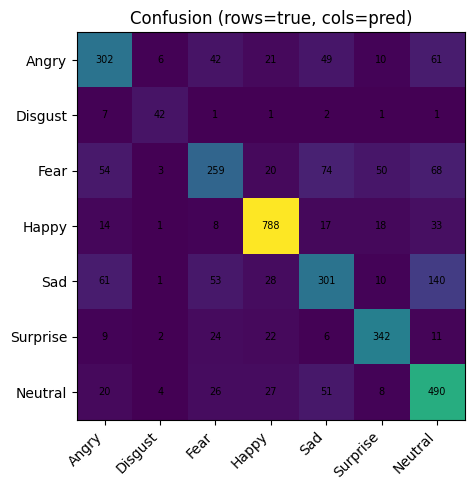

   Angry: 61.51%
 Disgust: 76.36%
    Fear: 49.05%
   Happy: 89.65%
     Sad: 50.67%
Surprise: 82.21%
 Neutral: 78.27%


In [68]:
# === Cell 19: Confusion matrix + per-class accuracy (test) ===
import itertools
IDX2EMO = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Sad',5:'Surprise',6:'Neutral'}

@torch.no_grad()
def confusion_matrix_and_report(model, loader, num_classes=7, use_ema=True):
    ema_local = globals().get("ema_obj", None)
    if use_ema and ema_local is not None: ema_local.apply_shadow(model)
    model.eval(); cm=torch.zeros(num_classes,num_classes,dtype=torch.int64)
    for xb, yb in loader:
        xb, yb = xb.to(model.device), yb.to(model.device)
        xb = ((xb/255.) - 0.5) * 2.0
        preds = model(xb).argmax(1)
        for t,p in zip(yb.view(-1), preds.view(-1)):
            cm[t.long(), p.long()] += 1
    if use_ema and ema_local is not None: ema_local.restore(model)
    denom = cm.sum(1).clamp(min=1).cpu().numpy()
    per_class = (cm.diag().cpu().numpy() / denom) * 100.0
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,5)); plt.imshow(cm.cpu()); plt.title("Confusion (rows=true, cols=pred)")
    plt.xticks(range(7), [IDX2EMO[i] for i in range(7)], rotation=45, ha='right')
    plt.yticks(range(7), [IDX2EMO[i] for i in range(7)])
    for i,j in itertools.product(range(7), range(7)):
        if cm[i,j]>0: plt.text(j,i,int(cm[i,j]),ha='center',va='center',fontsize=7)
    plt.tight_layout(); plt.show()
    for i,a in enumerate(per_class):
        print(f"{IDX2EMO[i]:>8s}: {a:.2f}%")

confusion_matrix_and_report(model, test_dl, use_ema=True)


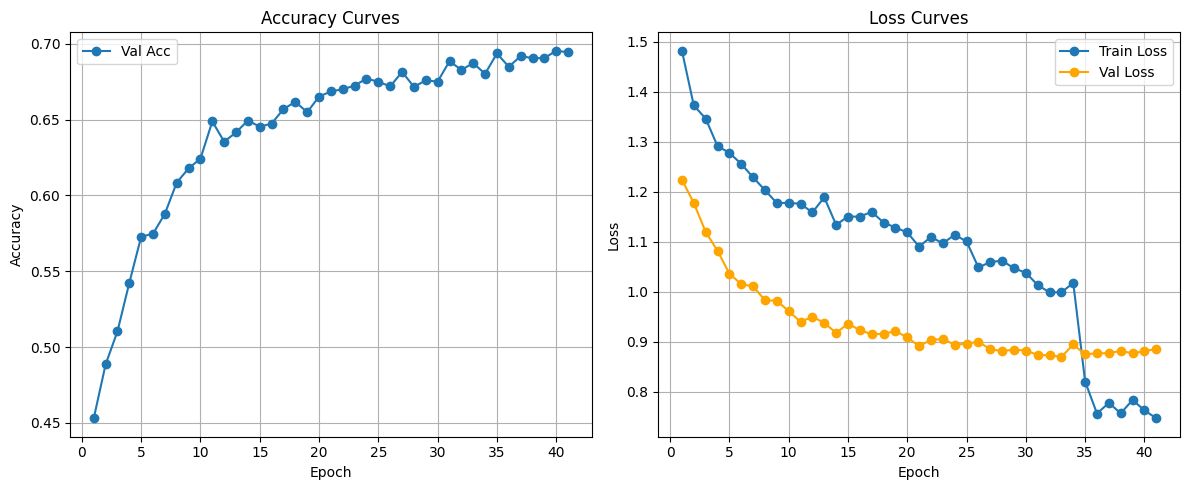

In [78]:
# === Cell: Plot Accuracy and Loss Curves ===
import matplotlib.pyplot as plt

# Example structure of history:
# history = [
#   {'epoch': 1, 'train_loss': 1.45, 'val_loss': 1.22, 'train_acc': 0.46, 'val_acc': 0.48, 'test_acc': 0.47},
#   {'epoch': 2, 'train_loss': 1.38, 'val_loss': 1.18, 'train_acc': 0.51, 'val_acc': 0.53, 'test_acc': 0.52},
#   ...
# ]

epochs     = [m['epoch']      for m in history]
train_loss = [m.get('train_loss') for m in history]
val_loss   = [m.get('val_loss')   for m in history]
train_acc  = [m.get('train_acc')  for m in history]
val_acc    = [m.get('val_acc')    for m in history]

# If you logged test_acc per epoch
test_acc   = [m.get('test_acc') for m in history] if 'test_acc' in history[0] else None

plt.figure(figsize=(12,5))

# 1. Accuracy plot
plt.subplot(1,2,1)
if train_acc[0] is not None:
    plt.plot(epochs, train_acc, label="Train Acc", marker='o')
plt.plot(epochs, val_acc, label="Val Acc", marker='o')
if test_acc is not None and any(v is not None for v in test_acc):
    plt.plot(epochs, test_acc, label="Test Acc", marker='x')
elif 'test_post' in globals():
    plt.axhline(test_post, color='red', linestyle='--', label=f"Final Test Acc = {test_post:.4f}")
plt.title("Accuracy Curves")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True)

# 2. Loss plot
plt.subplot(1,2,2)
if train_loss[0] is not None:
    plt.plot(epochs, train_loss, label="Train Loss", marker='o')
plt.plot(epochs, val_loss, label="Val Loss", marker='o', color='orange')
plt.title("Loss Curves")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()


# === Cell 21: FLOPs (fvcore) + Accuracy/GFLOP ===

In [69]:
%pip install fvcore


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=55e7b721d86f7ef9b255ec252ea20bc70b47f5c8b90d8ac85c494b377d5bf2cd
  Stored in directory: /root/.cache/pip/wheels/ed/9f/a5/e4f5b27454ccd4596bd8b62432c7d6b1ca9fa22aef9d70a16a
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=659994305df3b06ec5982643c1d945ae595e75130ba2191dc533308522ad872a
  Stored in directory: /root/.cache/pip/wheels/7c/96/04/4f5f31ff812f684f69f40cb1634357812220aac58d4698048c
Successfully built fvcore iopath


In [70]:
# === Cell 21: FLOPs (fvcore) + Accuracy/GFLOP ===
import importlib, subprocess
try:
    from fvcore.nn import FlopCountAnalysis
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "fvcore"])
    from fvcore.nn import FlopCountAnalysis

model.eval()
# FLOPs don't depend on value scale; this shape matches the model's 1-channel input.
dummy = torch.randn(1, 1, CONFIG["IMG_SIZE"], CONFIG["IMG_SIZE"], device=model.device)
total_flops = FlopCountAnalysis(model, (dummy,)).total()
MFLOPs = total_flops / 1e6
GFLOPs = total_flops / 1e9
print(f"[FLOPs] {GFLOPs:.4f} GFLOPs per forward")

def best_acc(*vals):
    vals=[v for v in vals if isinstance(v,(float,int))]
    return max(vals) if vals else None

acc_best_val  = best_acc(val_acc_base, val_acc_ema)
acc_best_test = best_acc(test_acc_base, test_acc_ema, test_acc_tta)

def efficiency_pct_per_gflop(acc_frac, gflops): return (acc_frac*100.0)/gflops

if acc_best_test is not None and GFLOPs>0:
    print(f"[Efficiency] Test Accuracy/GFLOP: {efficiency_pct_per_gflop(acc_best_test, GFLOPs):.2f} (% per GFLOP)")


features.1.0.stochastic_depth, features.2.0.stochastic_depth, features.2.1.stochastic_depth, features.3.0.stochastic_depth, features.3.1.stochastic_depth, features.4.0.stochastic_depth, features.4.1.stochastic_depth, features.4.2.stochastic_depth, features.5.0.stochastic_depth, features.5.1.stochastic_depth, features.5.2.stochastic_depth, features.6.0.stochastic_depth, features.6.1.stochastic_depth, features.6.2.stochastic_depth, features.6.3.stochastic_depth, features.7.0.stochastic_depth


[FLOPs] 0.0747 GFLOPs per forward
[Efficiency] Test Accuracy/GFLOP: 943.19 (% per GFLOP)


In [71]:
# =========================
# TESTING: accuracy + image predictions
# =========================
import torch, numpy as np
from PIL import Image
import torchvision.transforms.functional as VF

# --- Class names for readability ---
CLASS_NAMES = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

# --- Normalisation used for eval ---
def _to_m11(x: torch.Tensor) -> torch.Tensor:
    # x in [0,255] (uint8/float) -> float in [-1,1]
    return ((x.float() / 255.0) - 0.5) * 2.0

# --- 1) Load the trained checkpoint ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ckpt_path = str(CONFIG.get("SAVE_BEST_PATH", ""))  # e.g., "project/checkpoints/best_fer.pth"
assert ckpt_path, "CONFIG['SAVE_BEST_PATH'] is empty; set the checkpoint path first."

# Rebuild model skeleton exactly as trained
model = HybridEffNet(num_classes=7, classifier_dropout=0.30, use_cbam=True).to(device)
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["model_state"], strict=True)
model.eval()

# --- 2) Compute and print test accuracy (PrivateTest) ---
@torch.no_grad()
def eval_accuracy(model, loader) -> float:
    model.eval()
    correct, total = 0, 0
    for xb, yb in loader:
        xb = _to_m11(xb.to(device, non_blocking=True))
        yb = yb.to(device, non_blocking=True)
        logits = model(xb)
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item()
        total   += yb.numel()
    return correct / max(1, total)

test_acc = eval_accuracy(model, test_dl)
print(f"[Test] accuracy (PrivateTest) = {test_acc:.4f}")

# --- 3a) Predict a few samples from the FER2013 test loader ---
@torch.no_grad()
def preview_test_predictions(model, loader, n=12):
    model.eval()
    xb, yb = next(iter(loader))                 # one batch
    xb = xb[:n]                                 # first n images
    gt = yb[:n].cpu().numpy()
    xb_dev = _to_m11(xb.to(device, non_blocking=True))
    logits = model(xb_dev)
    probs  = logits.softmax(1).cpu().numpy()
    pred   = probs.argmax(1)
    # print a small table
    print("\n[Index]  Pred (pmax)     |  GT")
    for i in range(n):
        pclass = int(pred[i]); gclass = int(gt[i])
        pmax   = float(probs[i, pclass])
        print(f"{i:>6d}  {CLASS_NAMES[pclass]:<12s} ({pmax:0.3f}) |  {CLASS_NAMES[gclass]}")
    return pred, gt

_ = preview_test_predictions(model, test_dl, n=12)

# --- 3b) Predict arbitrary external images (file paths) ---
@torch.no_grad()
def predict_images(model, image_paths):
    """
    image_paths: List[str] to arbitrary images.
    Preprocessing: grayscale -> resize to 96x96 -> tensor [1,H,W] -> [-1,1].
    """
    model.eval()
    batch = []
    for path in image_paths:
        img = Image.open(path).convert("L")            # force grayscale
        img = img.resize((CONFIG["IMG_SIZE"], CONFIG["IMG_SIZE"]), Image.BILINEAR)
        x = torch.from_numpy(np.array(img, dtype=np.uint8))[None, ...]  # [1,H,W] uint8
        batch.append(x)
    xb = torch.stack(batch, dim=0)                     # [B,1,H,W]
    xb = _to_m11(xb).to(device, non_blocking=True)
    logits = model(xb)
    probs  = logits.softmax(1).cpu().numpy()
    preds  = probs.argmax(1)
    # pretty-print
    print("\n[External Image Predictions]")
    for path, p in zip(image_paths, preds):
        print(f"{path}  ->  {CLASS_NAMES[int(p)]} (p={probs[list(preds).index(p), int(p)]:.3f})")
    return preds, probs

# Example usage for external files (uncomment and set your paths):
# preds, probs = predict_images(model, [
#     "/content/some_face1.png",
#     "/content/some_face2.jpg",
# ])


[Test] accuracy (PrivateTest) = 0.6982

[Index]  Pred (pmax)     |  GT
     0  Fear         (0.390) |  Angry
     1  Sad          (0.557) |  Surprise
     2  Fear         (0.681) |  Neutral
     3  Sad          (0.366) |  Sad
     4  Fear         (0.262) |  Fear
     5  Angry        (0.801) |  Angry
     6  Sad          (0.399) |  Sad
     7  Happy        (0.688) |  Happy
     8  Fear         (0.479) |  Angry
     9  Happy        (0.767) |  Happy
    10  Happy        (0.581) |  Surprise
    11  Happy        (0.685) |  Happy


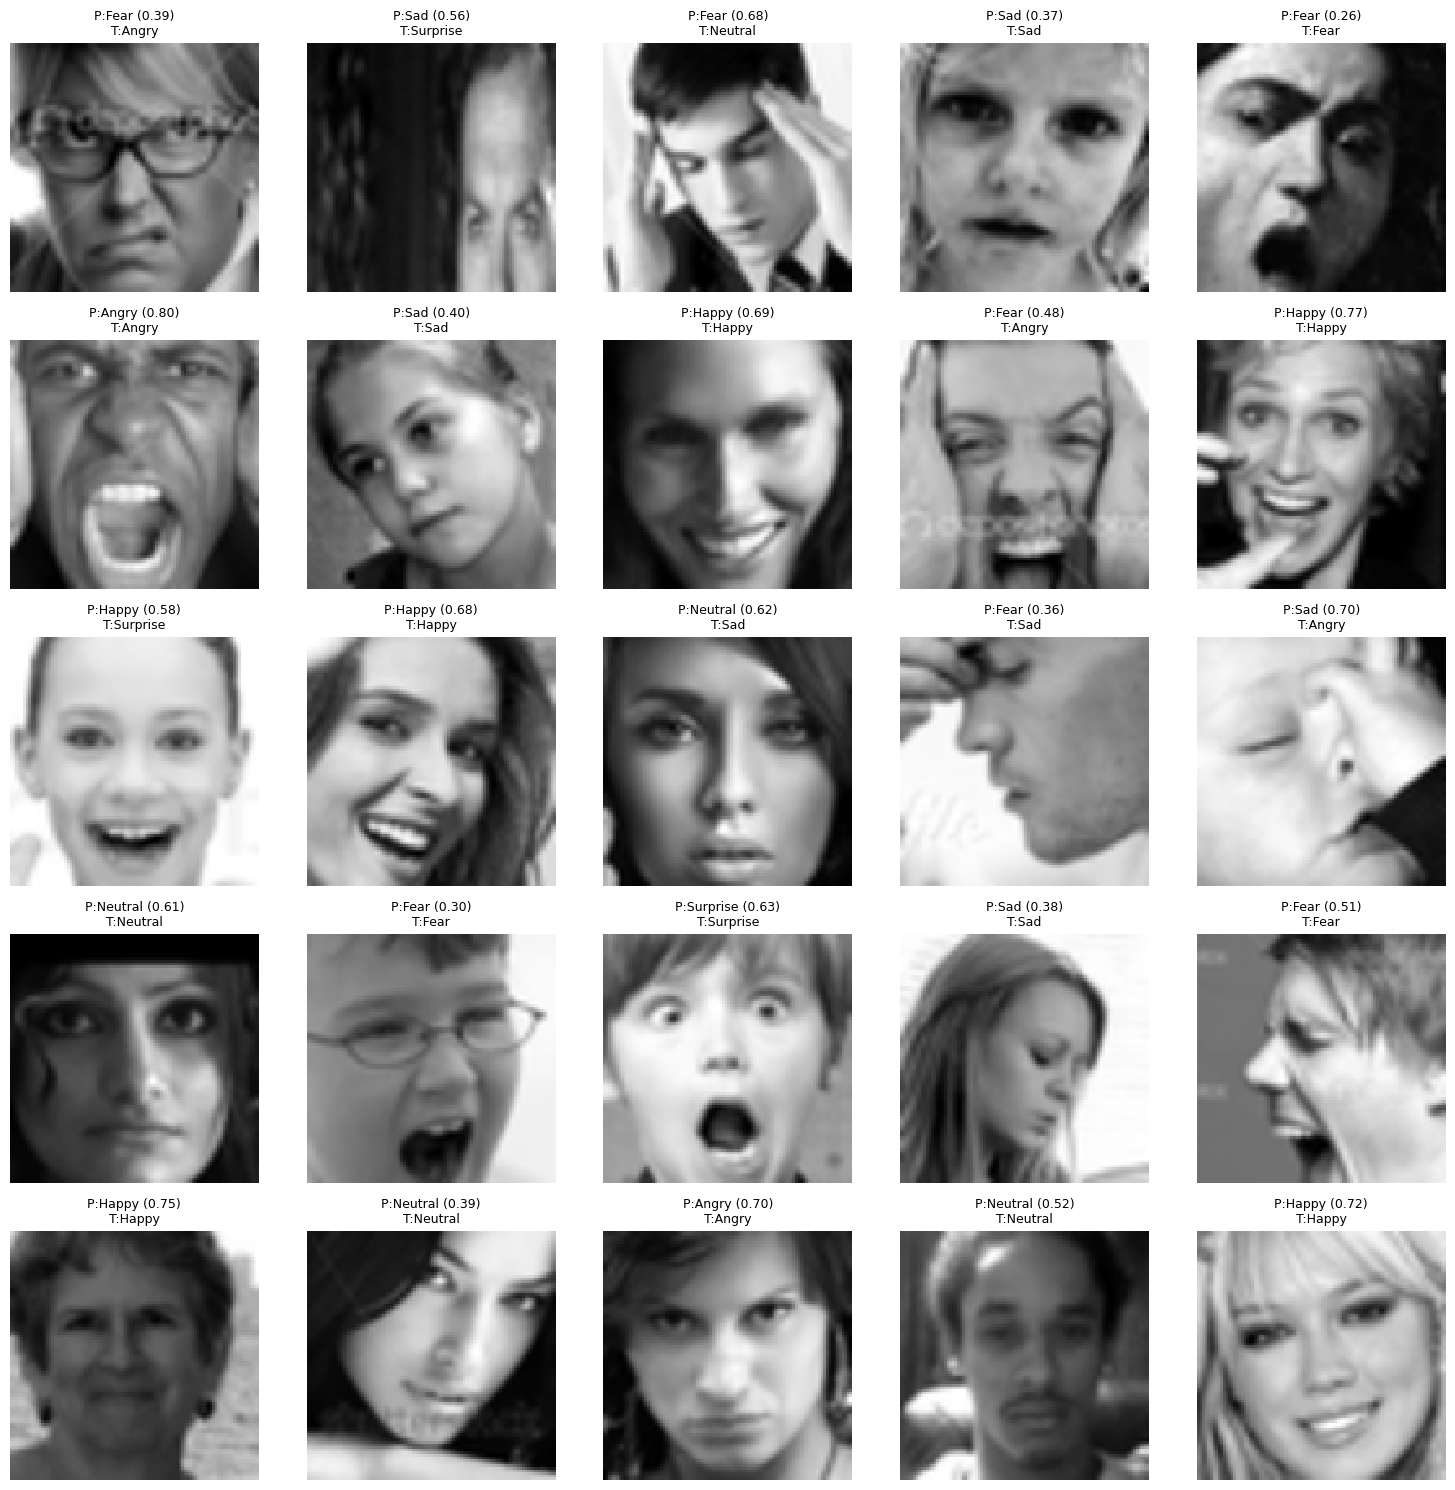

In [73]:
# === Cell B: Visualize predictions on Test images (robust / auto-range) ===
import torch, numpy as np, matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Class names (adjust if your label order differs)
Labels = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

# If you used my BN-recal cell, EVAL_TF may exist. Otherwise this stays None.
EVAL_TF = globals().get('EVAL_TF', None)

def _transform_includes_normalize(transform) -> bool:
    """Detects torchvision.transforms.Normalize inside a Compose-like transform."""
    try:
        from torchvision.transforms import Normalize
        seq = getattr(transform, 'transforms', None)
        return any(isinstance(t, Normalize) for t in (seq or []))
    except Exception:
        return False

@torch.no_grad()
def _model_ready_batch(xb: torch.Tensor, dev: torch.device) -> torch.Tensor:
    """
    Returns a tensor ready for the model:
    - If val/test transform already contains Normalize(0.5,0.5), pass through.
    - Otherwise apply explicit ((x/255)-0.5)*2 normalization.
    """
    xb = xb.to(dev, non_blocking=True)
    need_explicit_norm = True
    if EVAL_TF is not None and _transform_includes_normalize(EVAL_TF):
        need_explicit_norm = False
    if need_explicit_norm:
        xb = ((xb / 255.0) - 0.5) * 2.0
    return xb

def _to_display(img: torch.Tensor) -> np.ndarray:
    """
    Convert a single image tensor to HxW in [0,1] for imshow.
    Works for uint8 [0,255], float [0,1], or float [-1,1].
    """
    x = img.detach().cpu()
    if x.ndim == 3 and x.size(0) == 1:  # [1,H,W] -> [H,W]
        x = x[0]
    x = x.float()
    m, M = float(x.min()), float(x.max())
    if M > 1.5:          # likely uint8 [0,255]
        x = x / 255.0
    elif m < -0.25:      # likely [-1,1]
        x = (x * 0.5) + 0.5
    x = x.clamp(0, 1)
    return x.numpy()

@torch.no_grad()
def fetch_batch_and_predict(model, loader: DataLoader):
    """Fetch first batch from loader, run model, return (xb_raw, yb, pred, conf)."""
    model.eval()
    dev = next(model.parameters()).device
    xb, yb = next(iter(loader))
    xb_for_model = _model_ready_batch(xb.clone(), dev)
    logits = model(xb_for_model)
    probs = torch.softmax(logits, dim=1)
    pred  = probs.argmax(1)
    conf  = probs.max(1).values
    return xb, yb, pred.cpu(), conf.cpu()

# If you want EMA weights evaluated, uncomment:
# try: ema_tail.apply_shadow(model)
# except NameError: pass

xb, yb, pred, conf = fetch_batch_and_predict(model, test_dl)

# --- Grid render ---
K = min(25, xb.size(0))   # number of images to show
cols = 5
rows = int(np.ceil(K / cols))
plt.figure(figsize=(cols * 3, rows * 3))

for i in range(K):
    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(_to_display(xb[i]), cmap='gray', interpolation='nearest')
    t = Labels[int(yb[i])]
    p = Labels[int(pred[i])]
    c = float(conf[i])
    ax.set_title(f"P:{p} ({c:.2f})\nT:{t}", fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

# If you applied EMA above and want to revert to base weights, uncomment:
# try: ema_tail.restore(model)
# except NameError: pass


# === Cell 22: Save final checkpoint & reload sanity ===


In [74]:
# === Cell 22: Save final checkpoint & reload sanity ===
FINAL_PATH = CKPT_DIR / "final_fer_model.pth"
torch.save({"model_state": model.state_dict()}, FINAL_PATH)
print(f"[Save] {FINAL_PATH}")

ckpt = torch.load(FINAL_PATH, map_location="cpu")
model.load_state_dict(ckpt["model_state"]); model.to(model.device).eval()
with torch.no_grad():
    xb, yb = next(iter(val_dl))
    xb = ((xb/255.) - 0.5) * 2.0
    out = model(xb.to(model.device))
print("[Reload] Sanity forward OK:", tuple(out.shape))


[Save] project/checkpoints/final_fer_model.pth
[Reload] Sanity forward OK: (384, 7)
